In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

#os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

2023-08-07 14:15:57.630483: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-07 14:15:57.680006: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-07 14:15:57.681110: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 14:15:58.463859: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

#### Subsampling is made to get rid of host machine's memory and hls4ml vector multiplication size (4096) issue.
#### At every layer, the number of weights per neuron x number of neuron should be less than 4096, i.e 
#### w = layer.get_weights();  layersize = numpy.prod(w.shape); layersize must be less than 4096 
##### Taking every 3rd pixel.

In [3]:
import pickle
with open('MNIST_dataset.pkl', 'rb') as file:
    mnist_dataset = pickle.load(file)

for dataset in mnist_dataset:
    print(dataset.shape)
    
X_train_val, X_test, y_train_val, y_test = mnist_dataset[0], mnist_dataset[2], mnist_dataset[1], mnist_dataset[3]

#Subsampling every third pixel
X_Train_val =  np.zeros((len(X_train_val), 261))
X_Test = np.zeros((len(X_test), 261))
for i in range(len(X_train_val)):
    X_Train_val[i] = X_train_val[i][0:783:3]    
for i in range(len(X_test)):
    X_Test[i] = X_test[i][0:783:3]   
X_train_val = X_Train_val
X_test = X_Test
print('Sumsampled shape: ',X_train_val.shape, X_test.shape)

le = LabelEncoder()
y_train_val = le.fit_transform(y_train_val)
y_train_val = to_categorical(y_train_val, 10)
y_test = to_categorical(y_test, 10)


scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

(50000, 784)
(50000,)
(10000, 784)
(10000,)
Sumsampled shape:  (50000, 261) (10000, 261)


## Train sparse


In [51]:
import keras

model = Sequential()
model.add(Dense(10, input_shape=(261,)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model_losses = []
model_accs = []
class LossHistory(keras.callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.losses = []
            self.batches = []
            self.weight_save = []
            self.model_weights = model.get_weights()
            self.weight_masks = []
            for i in range(len(self.model_weights)):
                if i%2 == 0:
                    self.random_mask = np.logical_and(np.random.randint(0,2,self.model_weights[i].shape), np.random.randint(0,2,self.model_weights[i].shape))
                    for j in range(0):
                        self.random_mask = np.logical_and(self.random_mask, np.random.randint(0,2,self.model_weights[i].shape))
                    self.weight_masks.append(self.random_mask)
            for i in range(len(self.model_weights)):
                if i == 0:
                    self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[int(i/2)])
            model.set_weights(self.model_weights)
            self.weight_save.append(model.get_weights)       

        def on_batch_end(self, batch, logs={}):
            self.losses.append(logs.get('loss'))
            self.batches.append(batch)
            self.model_weights = model.get_weights()
            for i in range(len(self.model_weights)):
                if i %2 == 0:
                    self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[int(i/2)])
            model.set_weights(self.model_weights)
            self.weight_save.append(model.get_weights) 
            
l_history=LossHistory()
history = model.fit(X_train_val, y_train_val,
          batch_size=128, epochs=50, verbose=1,
          validation_data=(X_test, y_test), callbacks = [l_history])

loss_and_metrics = model.evaluate(X_test, y_test, verbose=2)
model_losses.append(loss_and_metrics[0])
model_accs.append(loss_and_metrics[1])
print(model_losses, model_accs)

Epoch 1/50
  1/391 [..............................] - ETA: 1:54 - loss: 2.4780 - accuracy: 0.1016WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0012s vs `on_train_batch_end` time: 0.0013s). Check your callbacks.


391/391 [==============================] - 2s 4ms/step - loss: 1.4192 - accuracy: 0.5861 - val_loss: 0.9472 - val_accuracy: 0.7448
Epoch 2/50
391/391 [==============================] - 1s 3ms/step - loss: 0.8575 - accuracy: 0.7575 - val_loss: 0.7593 - val_accuracy: 0.7836
Epoch 3/50
391/391 [==============================] - 1s 2ms/step - loss: 0.7432 - accuracy: 0.7812 - val_loss: 0.6943 - val_accuracy: 0.7934
Epoch 4/50
391/391 [==============================] - 1s 2ms/step - loss: 0.6954 - accuracy: 0.7911 - val_loss: 0.6639 - val_accuracy: 0.8020
Epoch 5/50
391/391 [==============================] - 1s 2ms/step - loss: 0.6705 - accuracy: 0.7974 - val_loss: 0.6471 - val_accuracy: 0.8030
Epoch 6/50
391/391 [==============================] - 1s 3ms/step - loss: 0.6558 - accuracy: 0.8004 - val_loss: 0.6379 - val_accuracy: 0.8059
Epoch 7/50
391/391 [==============================] - 1s 3ms/step - loss: 0.6464 - accuracy: 0.8028 - val_loss: 0.6319 - val_accuracy: 0.8066
Epoch 8/50
391/39

## Check sparsity
Make a quick check that the model was indeed trained sparse. We'll just make a histogram of the weights of the 1st layer, and hopefully observe a large peak in the bin containing '0'. Note logarithmic y axis.

% of zeros = 0.7352490421455938


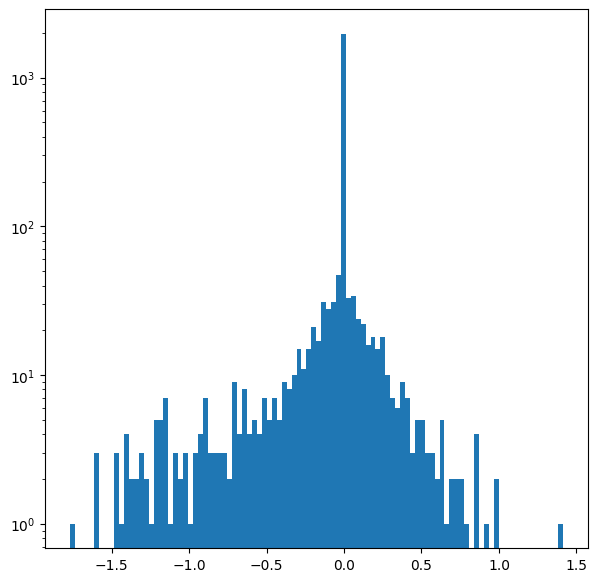

In [52]:
w = model.layers[0].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7, 7))
plt.bar(b[:-1], h, width=b[1] - b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w == 0) / np.size(w)))

### Unsparsed Model Performance

In [53]:
import keras

Unsparsemodel = Sequential()
Unsparsemodel.add(Dense(10, input_shape=(261,)))
Unsparsemodel.add(Activation('softmax'))

Unsparsemodel.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model_losses = []
model_accs = []
            
history = Unsparsemodel.fit(X_train_val, y_train_val,
          batch_size=128, epochs=50, verbose=1,
          validation_data=(X_test, y_test))

loss_and_metrics = Unsparsemodel.evaluate(X_test, y_test, verbose=2)
model_losses.append(loss_and_metrics[0])
model_accs.append(loss_and_metrics[1])
print(model_losses, model_accs)

Epoch 1/50
391/391 [==============================] - 1s 2ms/step - loss: 0.8560 - accuracy: 0.7517 - val_loss: 0.4438 - val_accuracy: 0.8808
Epoch 2/50
391/391 [==============================] - 1s 1ms/step - loss: 0.4182 - accuracy: 0.8845 - val_loss: 0.3629 - val_accuracy: 0.8997
Epoch 3/50
391/391 [==============================] - 1s 2ms/step - loss: 0.3584 - accuracy: 0.8997 - val_loss: 0.3356 - val_accuracy: 0.9086
Epoch 4/50
391/391 [==============================] - 1s 2ms/step - loss: 0.3313 - accuracy: 0.9063 - val_loss: 0.3226 - val_accuracy: 0.9115
Epoch 5/50
391/391 [==============================] - 1s 1ms/step - loss: 0.3159 - accuracy: 0.9105 - val_loss: 0.3171 - val_accuracy: 0.9129
Epoch 6/50
391/391 [==============================] - 1s 2ms/step - loss: 0.3057 - accuracy: 0.9131 - val_loss: 0.3157 - val_accuracy: 0.9157
Epoch 7/50
391/391 [==============================] - 1s 1ms/step - loss: 0.2987 - accuracy: 0.9151 - val_loss: 0.3118 - val_accuracy: 0.9157
Epoch 

## Check percentage of zeros in this unsparsed model.

% of zeros = 0.0


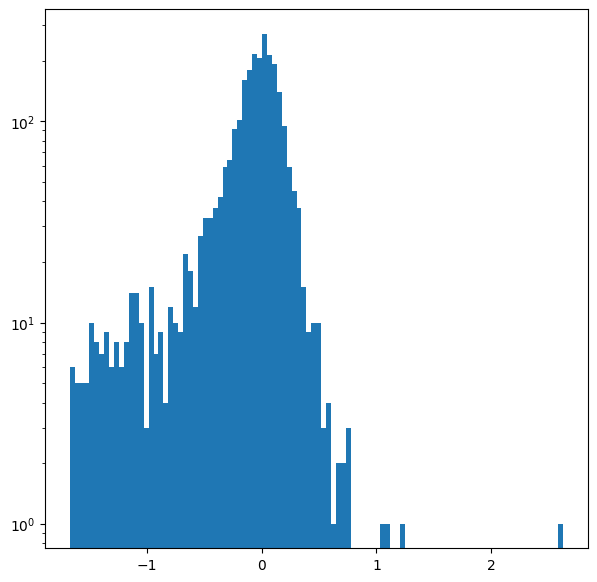

In [54]:
w = Unsparsemodel.layers[0].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7, 7))
plt.bar(b[:-1], h, width=b[1] - b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w == 0) / np.size(w)))

## Convert the model to FPGA firmware with hls4ml
Let's use the default configuration: `ap_fixed<16,6>` precision everywhere and `ReuseFactor=1`, so we can compare with the part 1 model. We need to use `strip_pruning` to change the layer types back to their originals.

**The synthesis will take a while**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_2/hls4ml_prj/vivado_hls.log`

In [55]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='model')
print(config)
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_Sparse_MNIST/hls4ml_prj', part='xc7a200tfbg676-2'
)
hls_model.compile()
hls_model.build(csim=False)

Interpreting Sequential
Topology:
Layer name: dense_48_input, layer type: InputLayer, input shapes: [[None, 261]], output shape: [None, 261]
Layer name: dense_48, layer type: Dense, input shapes: [[None, 261]], output shape: [None, 10]
Layer name: activation_46, layer type: Softmax, input shapes: [[None, 10]], output shape: [None, 10]
{'Model': {'Precision': 'fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency', 'BramFactor': 1000000000, 'TraceOutput': False}}
Interpreting Sequential
Topology:
Layer name: dense_48_input, layer type: InputLayer, input shapes: [[None, 261]], output shape: [None, 261]
Layer name: dense_48, layer type: Dense, input shapes: [[None, 261]], output shape: [None, 10]
Layer name: activation_46, layer type: Softmax, input shapes: [[None, 10]], output shape: [None, 10]
Creating HLS model
Writing HLS project
Done

****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2018.3 (64-bit)
  **** SW Build 2405991 on Thu Dec  6 23:36:41 MST 2018
  **** IP 

INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::softmax_stable<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, softmax_config4>' (firmware/nnet_utils/nnet_activation.h:217:46).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' (firmware/nnet_utils/nnet_dense_latency.h:17:48).
INFO: [HLS 200-489] Unrolling loop 'Loop-1' (firmware/nnet_utils/nnet_activation.h:243) in function 'nnet::softmax_stable<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, softmax_config4>' completely with a factor of 10.
INFO: [HLS 200-489] Unrolling loop 'Loop-2' (firmware/nnet_utils/nnet_activation.h:252) in function 'nnet::softmax_stable<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, softmax_config4

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>'(firmware/nnet_utils/nnet_dense_latency.h:26:27) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0' by setting 'weights.V' to 'w2.V'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0'(firmware/nnet_utils/nnet_dense_latency.h:26:27) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0' by setting 'biases[0].V' to 'b2.V.0'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0'(firmware/nnet_utils/nnet_dense_latency.h:26:

INFO: [SCHED 204-61] Pipelining function 'dense_latency<ap_fixed,ap_fixed<16,6,5,3,0>,config2>.0.0.0.0.0.0.0.0.0.0.0'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 8.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 143.26 seconds; current allocated memory: 214.141 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Starting global binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 8.59 seconds; current allocated memory: 255.161 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'reduce_ap_fixed_18_8_0_0_0_4_Op_add_ap_fixed_18_8_0_0_0_s' 
INFO: [HLS 200-10] ------------------------------------------------------------

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'reduce_ap_fixed_18_8_0_0_0_4_Op_add_ap_fixed_18_8_0_0_0_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Generating core module 'myproject_mux_104_18_1_0': 4 instance(s).
INFO: [RTGEN 206-100] Finished creating RTL model for 'reduce_ap_fixed_18_8_0_0_0_4_Op_add_ap_fixed_18_8_0_0_0_s'.
INFO: [HLS 200-111]  Elapsed time: 11.88 seconds; current allocated memory: 359.119 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'softmax_stable_ap_fixed_ap_fixed_16_6_5_3_0_softmax_config4_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Generating core module 'myproject_mul_mul_17ns_18s_26_3_1': 10 instance(s).
INFO: [RTGEN 206-100] Finished creating RTL model for

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '4.105',
  'BestLatency': '35',
  'WorstLatency': '35',
  'IntervalMin': '5',
  'IntervalMax': '5',
  'BRAM_18K': '2',
  'DSP': '562',
  'FF': '71103',
  'LUT': '21024',
  'AvailableBRAM_18K': '730',
  'AvailableDSP': '740',
  'AvailableFF': '269200',
  'AvailableLUT': '129000'}}

## Check the reports
Print out the reports generated by Vivado HLS. Pay attention to the Utilization Estimates' section in particular this time.

In [57]:
hls4ml.report.read_vivado_report('model_Sparse_MNIST/hls4ml_prj/')

Found 1 solution(s) in model_Sparse_MNIST/hls4ml_prj//myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Mon Aug  7 16:11:33 2023

* Version:        2018.3 (Build 2405991 on Thu Dec 06 23:56:15 MST 2018)
* Project:        myproject_prj
* Solution:       solution1
* Product family: artix7
* Target device:  xc7a200tfbg676-2


== Performance Estimates
+ Timing (ns): 
    * Summary: 
    +--------+-------+----------+------------+
    |  Clock | Target| Estimated| Uncertainty|
    +--------+-------+----------+------------+
    |ap_clk  |   5.00|     4.105|        0.62|
    +--------+-------+----------+------------+

+ Latency (clock cycles): 
    * Summary: 
    +-----+-----+-----+-----+----------+
    |  Latency  |  Interval | Pipeline |
    | min | max | min | max |   Type   |
    +-----+-----+-----+-----+----------+
    |   35|   35|    5|    5| function |
    +-----+-----+-----+-----+-

Print the report for the model trained in part 1. Remember these models have the same architecture, but the model in this section was trained using the sparsity API from tensorflow_model_optimization. Notice how the resource usage had dramatically reduced (particularly the DSPs). When Vivado HLS notices an operation like `y = 0 * x` it can avoid placing a DSP for that operation. The impact of this is biggest when `ReuseFactor = 1`, but still applies at higher reuse as well. **Note you need to have trained and synthesized the model from part 1**

### Compare it with Unsparsed model

In [58]:
config = hls4ml.utils.config_from_keras_model(Unsparsemodel, granularity='model')
print(config)
hls_model = hls4ml.converters.convert_from_keras_model(
    Unsparsemodel, hls_config=config, output_dir='model_UnSparse_MNIST/hls4ml_prj', part='xc7a200tfbg676-2'
)
hls_model.compile()
hls_model.build(csim=False)

Interpreting Sequential
Topology:
Layer name: dense_49_input, layer type: InputLayer, input shapes: [[None, 261]], output shape: [None, 261]
Layer name: dense_49, layer type: Dense, input shapes: [[None, 261]], output shape: [None, 10]
Layer name: activation_47, layer type: Softmax, input shapes: [[None, 10]], output shape: [None, 10]
{'Model': {'Precision': 'fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency', 'BramFactor': 1000000000, 'TraceOutput': False}}
Interpreting Sequential
Topology:
Layer name: dense_49_input, layer type: InputLayer, input shapes: [[None, 261]], output shape: [None, 261]
Layer name: dense_49, layer type: Dense, input shapes: [[None, 261]], output shape: [None, 10]
Layer name: activation_47, layer type: Softmax, input shapes: [[None, 10]], output shape: [None, 10]
Creating HLS model
Writing HLS project
Done

****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2018.3 (64-bit)
  **** SW Build 2405991 on Thu Dec  6 23:36:41 MST 2018
  **** IP 

INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::softmax_stable<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, softmax_config4>' (firmware/nnet_utils/nnet_activation.h:217:46).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' (firmware/nnet_utils/nnet_dense_latency.h:17:48).
INFO: [HLS 200-489] Unrolling loop 'Loop-1' (firmware/nnet_utils/nnet_activation.h:243) in function 'nnet::softmax_stable<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, softmax_config4>' completely with a factor of 10.
INFO: [HLS 200-489] Unrolling loop 'Loop-2' (firmware/nnet_utils/nnet_activation.h:252) in function 'nnet::softmax_stable<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, softmax_config4

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>'(firmware/nnet_utils/nnet_dense_latency.h:26:27) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0' by setting 'weights.V' to 'w2.V'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0'(firmware/nnet_utils/nnet_dense_latency.h:26:27) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0' by setting 'biases[0].V' to 'b2.V.0'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0'(firmware/nnet_utils/nnet_dense_latency.h:26:

INFO: [SCHED 204-61] Pipelining function 'dense_latency<ap_fixed,ap_fixed<16,6,5,3,0>,config2>.0.0.0.0.0.0.0.0.0.0.0'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 9.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 249.05 seconds; current allocated memory: 350.176 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Starting global binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 76.9 seconds; current allocated memory: 500.067 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'reduce_ap_fixed_18_8_0_0_0_4_Op_add_ap_fixed_18_8_0_0_0_s' 
INFO: [HLS 200-10] ------------------------------------------------------------

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'reduce_ap_fixed_18_8_0_0_0_4_Op_add_ap_fixed_18_8_0_0_0_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Generating core module 'myproject_mux_104_18_1_0': 4 instance(s).
INFO: [RTGEN 206-100] Finished creating RTL model for 'reduce_ap_fixed_18_8_0_0_0_4_Op_add_ap_fixed_18_8_0_0_0_s'.
INFO: [HLS 200-111]  Elapsed time: 63.21 seconds; current allocated memory: 842.906 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'softmax_stable_ap_fixed_ap_fixed_16_6_5_3_0_softmax_config4_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Generating core module 'myproject_mul_mul_17ns_18s_26_3_1': 10 instance(s).
INFO: [RTGEN 206-100] Finished creating RTL model for

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '4.105',
  'BestLatency': '36',
  'WorstLatency': '36',
  'IntervalMin': '5',
  'IntervalMax': '5',
  'BRAM_18K': '2',
  'DSP': '2067',
  'FF': '228552',
  'LUT': '71763',
  'AvailableBRAM_18K': '730',
  'AvailableDSP': '740',
  'AvailableFF': '269200',
  'AvailableLUT': '129000'}}

In [59]:
hls4ml.report.read_vivado_report('model_UnSparse_MNIST/hls4ml_prj/')

Found 1 solution(s) in model_UnSparse_MNIST/hls4ml_prj//myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Mon Aug  7 16:22:22 2023

* Version:        2018.3 (Build 2405991 on Thu Dec 06 23:56:15 MST 2018)
* Project:        myproject_prj
* Solution:       solution1
* Product family: artix7
* Target device:  xc7a200tfbg676-2


== Performance Estimates
+ Timing (ns): 
    * Summary: 
    +--------+-------+----------+------------+
    |  Clock | Target| Estimated| Uncertainty|
    +--------+-------+----------+------------+
    |ap_clk  |   5.00|     4.105|        0.62|
    +--------+-------+----------+------------+

+ Latency (clock cycles): 
    * Summary: 
    +-----+-----+-----+-----+----------+
    |  Latency  |  Interval | Pipeline |
    | min | max | min | max |   Type   |
    +-----+-----+-----+-----+----------+
    |   36|   36|    5|    5| function |
    +-----+-----+-----+-----